<a href="https://colab.research.google.com/github/alesaccoia/IULM_DDM2324_Notebooks/blob/main/18_BTYD_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizzo della libreria "lifetimes" per il calcolo del valore del cliente

In [ ]:
!pip install lifetimes

E' possibile caricare il dataset originale con le transazioni di CD NOW

In [4]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


"summary_data_from_transaction_data" crea il dataframe aggregato partendo dai dati raw

In [16]:
summary_data_from_transaction_data(transaction_data, "id", "date")

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0
...,...,...,...
4995,0.0,0.0,336.0
4996,4.0,80.0,293.0
4997,0.0,0.0,304.0


In alternativa, la libreria già fornisce il dataset aggregato

In [17]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


Vediamo ora la dimensionalitá del dataset:

In [18]:
data.shape

(2357, 3)

In [19]:
data.describe()

,frequency,recency,T
count,2357.000000,2357.000000,2357.000000
mean,1.042427,6.845787,32.715829
std,2.190014,10.731400,3.326906
min,0.000000,0.000000,27.000000
25%,0.000000,0.000000,29.860000
50%,0.000000,0.000000,32.710000
75%,1.000000,12.000000,35.430000
max,29.000000,38.430000,38.860000


# Utilizzo del Modello

Il modello Pareto/NBD viene importanto con l'oggetto BetaGeoFitter, che ha un API simile ai modelli di sklearn

In [20]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


Una volta che il modello é stato caricato, si possono visualizzare deo grafici interessanti.

Considera il seguente scenario: un cliente ha acquistato da te ogni giorno per tre settimane di fila, e non abbiamo più sentito nulla da loro da mesi. Quali sono le probabilità che siano ancora "attivi"? Piuttosto basse.

D'altra parte, un cliente che storicamente acquista da te una volta al trimestre e ha acquistato l'ultimo trimestre, è probabile che sia ancora attivo.

Possiamo visualizzare questa relazione utilizzando la matrice Frequenza/Tempo trascorso, che calcola il numero previsto di transazioni che un cliente artificiale effettuerà nel prossimo periodo di tempo, in base alla sua recente attività (età all'ultimo acquisto) e alla frequenza (il numero di transazioni ripetute che ha effettuato).

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

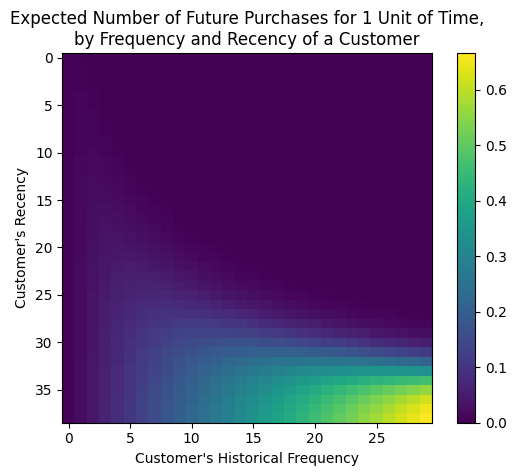

In [21]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)


Possiamo notare che se un cliente ha acquistato 25 volte da te e il suo ultimo acquisto è stato quando avevano 35 settimane di età (considerando che l'individuo ha 35 settimane di età), allora sono il tuo miglior cliente (in basso a destra). I tuoi clienti meno attivi si trovano nell'angolo in alto a destra: hanno acquistato molto rapidamente e non li abbiamo visti da settimane.

C'è anche quella "coda" intorno a (5,25). Rappresenta il cliente che acquista raramente, ma l'abbiamo visto di recente, quindi potrebbero acquistare di nuovo - non siamo sicuri se siano inattivi o semplicemente tra un acquisto e l'altro.

Un'altra matrice interessante da esaminare è la probabilità di essere ancora attivi:

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

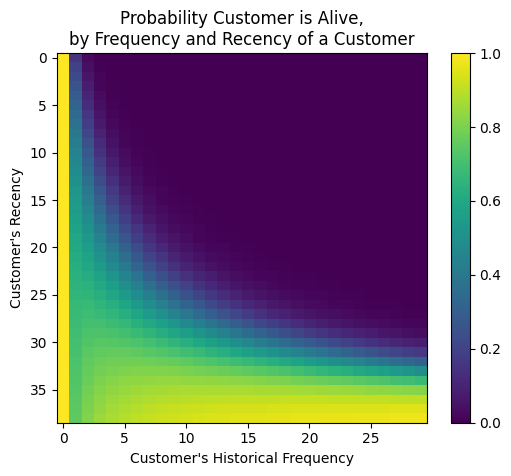

In [23]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Calcolo della probabilitá di acquisto nel periodo seguente

In [35]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.head()

,frequency,recency,T,predicted_purchases,predicted_purchases_amount
ID,,,,,
1,2,30.43,38.86,0.037443,54.672861
2,1,1.71,38.86,0.006065,9.117164
3,0,0.00,38.86,0.005586,8.828069
4,0,0.00,38.86,0.005586,8.828069
5,0,0.00,38.86,0.005586,8.828069


## Calcolo della probabilitá di acquisto nel periodo seguente (52 settimane)

In [25]:
t = 52
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                      data['frequency'],
                                                                                      data['recency'],
                                                                                      data['T'])

In [15]:
print(data.head())
print(data.shape)

    frequency  recency      T  predicted_purchases
ID                                                
1           2    30.43  38.86             2.397848
2           1     1.71  38.86             0.405271
3           0     0.00  38.86             0.402301
4           0     0.00  38.86             0.402301
5           0     0.00  38.86             0.402301
(2357, 4)


## Grafico della probabilità di un utente di essere ancora attivo

ConversionError: ignored

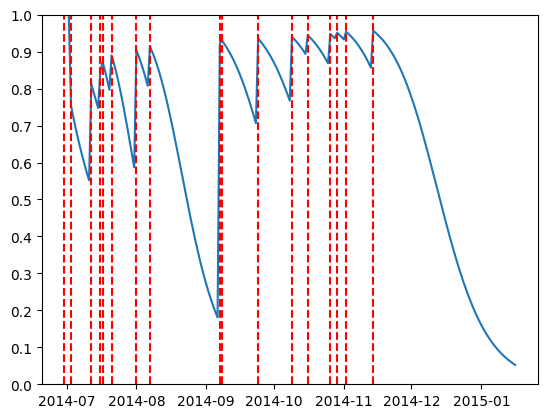

In [26]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

# Stima del CLV
Carichiamo il dataset con anche il valore delle transazioni

In [27]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


Il valore medio di una transazione di ritorno é:

In [33]:
mean_monetary_value = returning_customers_summary['monetary_value'].mean()
mean_monetary_value

35.07855179704017

Possiamo quindi unire quest'informazione al nostro dataset, che contiene la probabilitá di acquisti nelle prossime 52 settimane, nel seguente modo

In [34]:
data['predicted_purchases_amount'] = data['predicted_purchases'] * mean_monetary_value
CLV = data['predicted_purchases_amount'].sum() / data.shape[0]
print(CLV)

31.096220682427802


In [38]:
id = 35
print(data.iloc[id])


frequency                      0.000000
recency                        0.000000
T                             38.710000
predicted_purchases            0.005606
predicted_purchases_amount     8.855060
Name: 36, dtype: float64
